In [6]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg2.0")

import sparg
import tskit
import msprime
import math
import numpy as np
import warnings
import matplotlib.pyplot as plt
import scipy.stats as st
warnings.simplefilter("always")


def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=[]):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb : bool
        Whether to add msprime node flags

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.in1d(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    #keep_nodes = np.unique(np.concatenate((np.where((ts.tables.nodes.time <= keep_nodes_below) & (ts.tables.nodes.time % keep_nodes_step == 0))[0], recomb_nodes)))
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

def identify_all_nodes_above(ts, nodes):
    """Traverses all nodes above provided list of nodes

    Parameters
    ----------
    ts : tskit.TreeSequence
    nodes : list or numpy.ndarray
        Nodes to traverse above in the ARG. Do not need to be connected

    Returns
    -------
    above_samples : numpy.ndarray
        Sorted array of node IDs above the provided list of nodes
    """

    edges = ts.tables.edges
    above_samples = []
    while len(nodes) > 0:
        above_samples.append(nodes[0])
        parents = list(np.unique(edges[np.where(edges.child==nodes[0])[0]].parent))
        new_parents = []
        for p in parents:
            if (p not in nodes) and (p not in above_samples):
                new_parents.append(p)
        nodes = nodes[1:] + new_parents
    return np.sort(above_samples)

def chop_arg(ts, time):
    decap = ts.decapitate(time)
    subset = decap.subset(nodes=np.where(decap.tables.nodes.time <= time)[0])
    merged = sparg.merge_unnecessary_roots(ts=subset)
    return merged

In [7]:
ts = tskit.load("/Users/jameskitchens/Desktop/two_pops_distributed.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [8]:
ts_small, maps_small = simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []

subpop_and_seq_len = {sample:{ subpop:0 for subpop in range(2)} for sample in ts_small.samples()}

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for sample in tree.samples(root):
            subpop_and_seq_len[sample][subpop] += tree.span

for sample in subpop_and_seq_len:
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len[sample][1] / sum(subpop_and_seq_len[sample].values()))

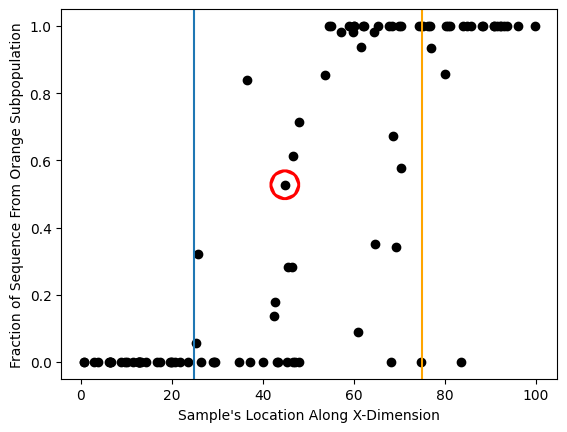

In [9]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[41], composition[41], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
plt.savefig("two_pops_composition.svg")
plt.show()

In [11]:
keep_nodes = identify_all_nodes_above(ts=ts_sim, nodes=[41])
ts_final, maps_final = simplify_with_recombination(ts=ts_sim, flag_recomb=True, keep_nodes=keep_nodes)
dispersal_rate, cov_mat, paths, locations_of_nodes, variances_in_node_locations = sparg.estimate_minimal_spatial_parameters(
    ts=ts_final,
    verbose=True,
    return_ancestral_node_positions=range(ts_final.num_nodes)
)

Prepared input parameters - Section Elapsed Time: 0.07769489288330078 - Total Elapsed Time: 0.07770204544067383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12152/12152 [00:24<00:00, 490.34it/s]


Calculated covariance matrix - Section Elapsed Time: 24.859451293945312 - Total Elapsed Time: 24.937324047088623
Inverted covariance matrix - Section Elapsed Time: 0.1291651725769043 - Total Elapsed Time: 25.06668210029602
Created root locations vector - Section Elapsed Time: 1.064408779144287 - Total Elapsed Time: 26.131118059158325
Estimated dispersal rate - Section Elapsed Time: 0.00043702125549316406 - Total Elapsed Time: 26.131638050079346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12152/12152 [00:15<00:00, 800.57it/s]


Reconstructed ancestral locations - Section Elapsed Time: 16.602023124694824 - Total Elapsed Time: 42.73384380340576


In [12]:
just_41, maps_41 = ts_final.simplify(samples=[41], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
paths_41 = sparg.identify_unique_paths(ts=just_41)

In [17]:
for bp in just_41.breakpoints():
    print(bp/1000000*6)

0.0
2.42931
2.566782
2.811096
3.1852919999999996
3.45027
4.184658000000001
5.6806920000000005
6.0


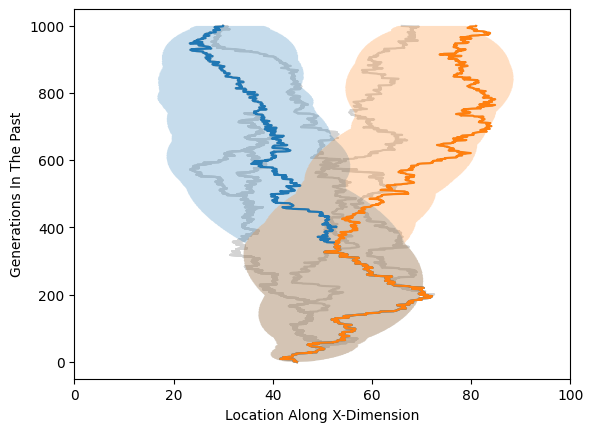

In [100]:
for i,path in enumerate(paths_41):# for i in (11,16)]:
    times = []
    true_locations = []
    estimated_locations = []
    estimated_left = []
    estimated_right = []
    for node in path:
        orig_id = np.argwhere(maps_41==node)[0][0]
        times.append(just_41.node(node).time)
        true_locations.append(just_41.individual(just_41.node(node).individual).location[0])
        estimated_locations.append(locations_of_nodes[orig_id][0])
        estimated_left.append(locations_of_nodes[orig_id][0]-(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
        estimated_right.append(locations_of_nodes[orig_id][0]+(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
    if i in (11,16):
        plt.plot(true_locations, times)
        plt.fill_betweenx(y=times, x1=estimated_left, x2=estimated_right, alpha=0.25, label="estimated")
    else:
        plt.plot(true_locations, times, color="lightgray", zorder=0)
plt.xlim(0, 100)
plt.xlabel("Location Along X-Dimension")
plt.ylabel("Generations In The Past")
plt.savefig("two_pops_genetic_ancestors.svg")
plt.show()

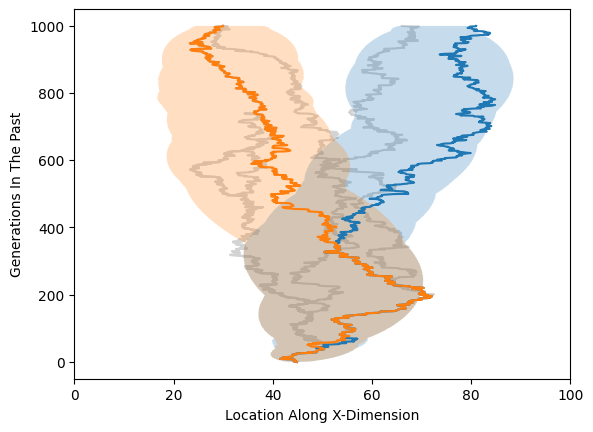

In [126]:
def ancestors(tree, u):
    """
    Returns an iterator over the ancestors of u in this tree.
    """
    u = tree.parent(u)
    while u != -1:
         yield u
         u = tree.parent(u)
 
paths_41 = []
for i, tree in enumerate(just_41.trees()):
    paths_41.append([0] + list(ancestors(tree, 0)))

for i,path in enumerate(paths_41):# for i in (11,16)]:
    times = []
    true_locations = []
    estimated_locations = []
    estimated_left = []
    estimated_right = []
    for node in path:
        orig_id = np.argwhere(maps_41==node)[0][0]
        times.append(just_41.node(node).time)
        true_locations.append(just_41.individual(just_41.node(node).individual).location[0])
        estimated_locations.append(locations_of_nodes[orig_id][0])
        estimated_left.append(locations_of_nodes[orig_id][0]-(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
        estimated_right.append(locations_of_nodes[orig_id][0]+(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
    if i in (0,6):
        plt.plot(true_locations, times)
        plt.fill_betweenx(y=times, x1=estimated_left, x2=estimated_right, alpha=0.25, label="estimated")
    else:
        plt.plot(true_locations, times, color="lightgray", zorder=0)
plt.xlim(0, 100)
plt.xlabel("Location Along X-Dimension")
plt.ylabel("Generations In The Past")
plt.savefig("two_pops_genetic_ancestors.svg")
plt.show()

In [ ]:
for sample in ts_small.samples():
    #keep_nodes = identify_all_nodes_above(ts=ts_small, nodes=[sample])
    #ts_single = ts_small.subset(nodes=keep_nodes)
    ts_single, maps_single = ts_small.simplify(samples=[sample], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)    
    #print(ts_single.tables)
    viz.D3ARG(ts=ts_single).draw(width=500, height=2000)
    break
    subpop_and_seq_len = {}
    for tree in ts_single.trees():
        true_location_of_root = ts_single.individual(ts_single.node(tree.root).individual).location[0]
        if true_location_of_root < 50:
            subpop = 0
        else:
            subpop = 1
        subpop_and_seq_len[subpop] = subpop_and_seq_len.get(subpop, 0) + tree.span
    #print(sample, subpop_and_seq_len)
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len.get(1, 0) / sum(subpop_and_seq_len.values()))

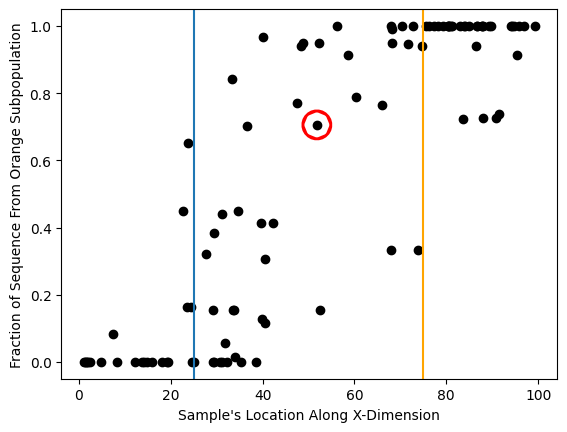

In [33]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[36], composition[36], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
#plt.savefig("two_pops_composition.svg")
plt.show()

Prepared input parameters - Section Elapsed Time: 0.16198110580444336 - Total Elapsed Time: 0.1619870662689209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26792/26792 [02:15<00:00, 197.90it/s]


Calculated covariance matrix - Section Elapsed Time: 135.6240837574005 - Total Elapsed Time: 135.78616619110107
Inverted covariance matrix - Section Elapsed Time: 0.24404406547546387 - Total Elapsed Time: 136.03039693832397
Created root locations vector - Section Elapsed Time: 0.8363339900970459 - Total Elapsed Time: 136.8668291568756
Estimated dispersal rate - Section Elapsed Time: 0.0005009174346923828 - Total Elapsed Time: 136.8674190044403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26792/26792 [00:59<00:00, 450.03it/s]


Reconstructed ancestral locations - Section Elapsed Time: 71.56318092346191 - Total Elapsed Time: 208.43061900138855


In [37]:
paths_36 = sparg.identify_unique_paths(ts_final, samples=[36])

KeyboardInterrupt: 

In [ ]:
for path in paths_36[i]:
    times = []
    true_locations = []
    estimated_locations = []
    estimated_left = []
    estimated_right = []
    for node in path:
        orig_id = node
        times.append(just_347.node(node).time)
        true_locations.append(just_347.individual(just_347.node(node).individual).location[0])
        estimated_locations.append(locations_of_nodes[orig_id][0])
        estimated_left.append(locations_of_nodes[orig_id][0]-(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
        estimated_right.append(locations_of_nodes[orig_id][0]+(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
    plt.plot(true_locations, times)
    plt.fill_betweenx(y=times, x1=estimated_left, x2=estimated_right, alpha=0.25, label="estimated")
plt.xlim(0, 100)
plt.show()

In [118]:
ts = tskit.load("/Users/jameskitchens/Desktop/two_pops_longer2.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 10, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [101]:
ts_small, maps_small = simplify_with_recombination(ts=ts_sim, flag_recomb=True)

In [114]:
location_x = []
composition = []
for sample in ts_small.samples():
    #keep_nodes = identify_all_nodes_above(ts=ts_small, nodes=[sample])
    #ts_single = ts_small.subset(nodes=keep_nodes)
    ts_single, maps_single = ts_small.simplify(samples=[sample], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)    
    print(ts_single.tables)
    viz.D3ARG(ts=ts_single).draw(width=500, height=2000)
    break
    subpop_and_seq_len = {}
    for tree in ts_single.trees():
        true_location_of_root = ts_single.individual(ts_single.node(tree.root).individual).location[0]
        if true_location_of_root < 50:
            subpop = 0
        else:
            subpop = 1
        subpop_and_seq_len[subpop] = roots_and_seq_len.get(subpop, 0) + tree.span
    #print(sample, subpop_and_seq_len)
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len.get(1, 0) / sum(subpop_and_seq_len.values()))

TableCollection

Sequence Length: 1000000.0
Time units: ticks
Metadata: {'SLiM': {'cycle': 2000, 'file_version': '0.8', 'model_type': 'nonWF', 'name': 'sim', 'nucleotide_based': False, 'separate_sexes': False, 'spatial_dimensionality': 'xy', 'spatial_periodicity': '', 'stage': 'late', 'tick': 2000}}

Individuals
╔══╤══════╤═══════════════════════════════════════════╤═══════╤════════════════════════════════════════╗
║id│flags │location                                   │parents│metadata                                ║
╠══╪══════╪═══════════════════════════════════════════╪═══════╪════════════════════════════════════════╣
║0 │327680│ 22.36594243377919, 53.414105446457405, 0.0│ -1, 92│{'pedigree_id': 16200557, 'pedigree_p...║
║1 │262144│                            58.0, 34.0, 0.0│       │{'pedigree_id': 204, 'pedigree_p1': -...║
║2 │262144│                            77.0, 72.0, 0.0│       │{'pedigree_id': 1911, 'pedigree_p1': ...║
║3 │262144│                            97.0, 49.0, 0.0│ 

ValueError: Node '7' not in the graph.

In [ ]:
plt.scatter(location_x, composition, color="black")
#plt.scatter(location_x[347], composition[347], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
#plt.savefig("two_pops_composition.svg")
plt.show()

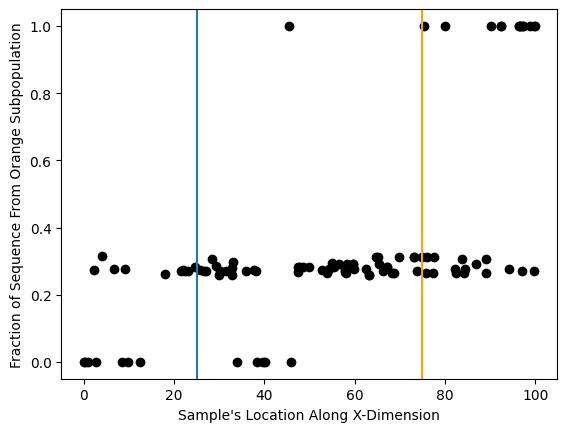

In [75]:
ts = tskit.load("/Users/jameskitchens/Desktop/two_pops_longer2.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
ts_small, maps_small = simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []
for sample in ts_small.samples():
    subpop_and_seq_len = {}
    ts_single, maps_single = ts_small.simplify(samples=[sample], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
    for tree in ts_single.trees():
        true_location_of_root = ts_single.individual(ts_single.node(tree.root).individual).location[0]
        if true_location_of_root < 50:
            subpop = 0
        else:
            subpop = 1
        subpop_and_seq_len[subpop] = roots_and_seq_len.get(subpop, 0) + tree.span
    #print(sample, subpop_and_seq_len)
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len.get(1, 0) / sum(subpop_and_seq_len.values()))
    
plt.scatter(location_x, composition, color="black")
#plt.scatter(location_x[347], composition[347], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
#plt.savefig("two_pops_composition.svg")
plt.show()

In [ ]:
keep_nodes = identify_all_nodes_above(ts=ts_sim, nodes=[347])
ts_final, maps_final = simplify_with_recombination(ts=ts_sim, flag_recomb=True, keep_nodes=keep_nodes)

In [85]:
#ts_final.dump("two_pops_simplified.trees")

dispersal_rate, cov_mat, paths, locations_of_nodes, variances_in_node_locations = sparg.estimate_minimal_spatial_parameters(
    ts=ts_final,
    verbose=True,
    return_ancestral_node_positions=range(ts_final.num_nodes)
)

Prepared input parameters - Section Elapsed Time: 0.06021714210510254 - Total Elapsed Time: 0.06022310256958008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10041/10041 [00:40<00:00, 246.44it/s]


Calculated covariance matrix - Section Elapsed Time: 40.77251696586609 - Total Elapsed Time: 40.832834005355835
Inverted covariance matrix - Section Elapsed Time: 0.9106838703155518 - Total Elapsed Time: 41.74367618560791
Created root locations vector - Section Elapsed Time: 1.5649220943450928 - Total Elapsed Time: 43.30868911743164
Estimated dispersal rate - Section Elapsed Time: 0.0011870861053466797 - Total Elapsed Time: 43.30995988845825


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10041/10041 [00:58<00:00, 171.62it/s]


Reconstructed ancestral locations - Section Elapsed Time: 60.08349394798279 - Total Elapsed Time: 103.39346885681152


In [ ]:
unique_paths = sparg.identify_unique_paths(ts=ts_small)

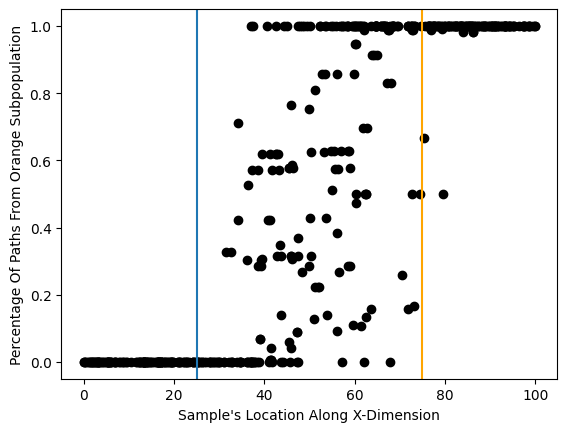

In [6]:
location_x = []
composition = []
num_paths = []
for sample in ts_small.samples():
    true_root_locations = []
    for path in unique_paths:
        if path[0] == sample:
            true_root_locations.append(ts_small.individual(ts_small.node(path[-1]).individual).location[0])
    location_x.append(ts_final.individual(ts_small.node(sample).individual).location[0])
    composition.append(sum(np.array(true_root_locations) > 50) / len(true_root_locations))
    num_paths.append(len(true_root_locations))


plt.scatter(location_x, composition, color="black")
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Percentage Of Paths From Orange Subpopulation")
#plt.savefig("two_pops_composition.svg")
plt.show()

In [63]:
location_x = []
composition = []
num_paths = []
for sample in ts_small.samples():
    true_root_locations = []
    roots = []
    for path in unique_paths:
        if path[0] == sample:
            roots.append(path[-1])
    for root in np.unique(roots):
        true_root_locations.append(ts_small.individual(ts_small.node(root).individual).location[0])
    location_x.append(ts_final.individual(ts_small.node(sample).individual).location[0])
    composition.append(sum(np.array(true_root_locations) > 50) / len(true_root_locations))
    num_paths.append(len(true_root_locations))

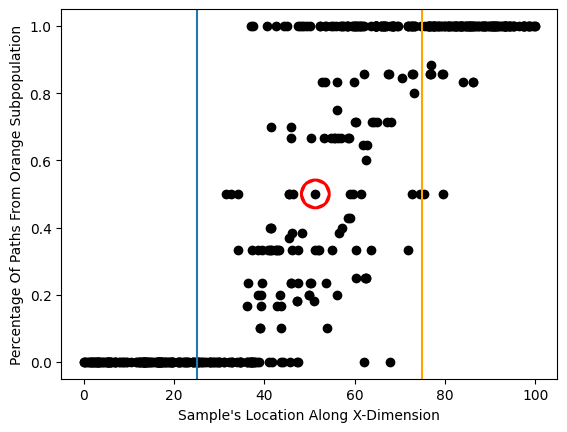

In [82]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[347], composition[347], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Percentage Of Paths From Orange Subpopulation")
#plt.savefig("two_pops_composition.svg")
plt.show()

In [132]:
location_x = []
composition = []
num_paths = []
for sample in ts_small.samples():
    ts_single, maps_single = ts_small.simplify(samples=[sample], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
    single_paths = sparg.identify_unique_paths(ts=ts_single)
    true_root_locations = []
    roots = []
    for path in single_paths:
        roots.append(path[-1])
    for root in np.unique(roots):
        true_root_locations.append(ts_single.individual(ts_single.node(root).individual).location[0])
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(sum(np.array(true_root_locations) > 50) / len(true_root_locations))
    num_paths.append(len(true_root_locations))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1093.12it/s]


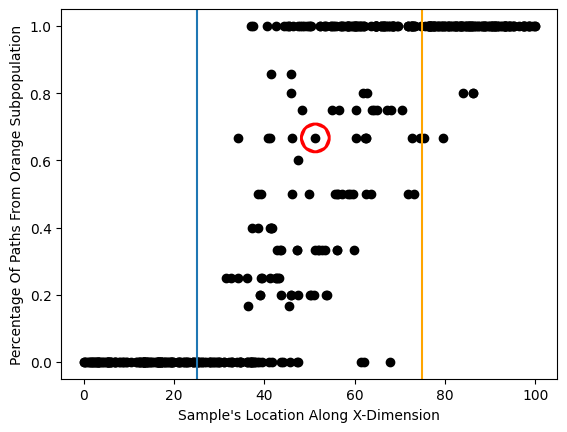

In [133]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[347], composition[347], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction Of Genetic Ancestors From Orange Subpopulation")
#plt.savefig("two_pops_composition.svg")
plt.show()

In [76]:
np.where(np.array(composition) == 0.5)

(array([ 17,  75, 195, 201, 239, 244, 347, 376, 433, 442, 457, 469, 486,
        487]),)

In [8]:
roots = []
for path in unique_paths:
    roots.append(path[-1])
print(np.unique(roots))

[4094 4095 4096 4097 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107
 4108 4109 4110 4111 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121
 4122 4123 4124 4125 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135
 4136 4137 4138 4139 4140 4141 4142 4143]


In [92]:
just_347, map_347 = ts_final.simplify(samples=[347], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
paths_347 = sparg.identify_unique_paths(ts=just_347)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


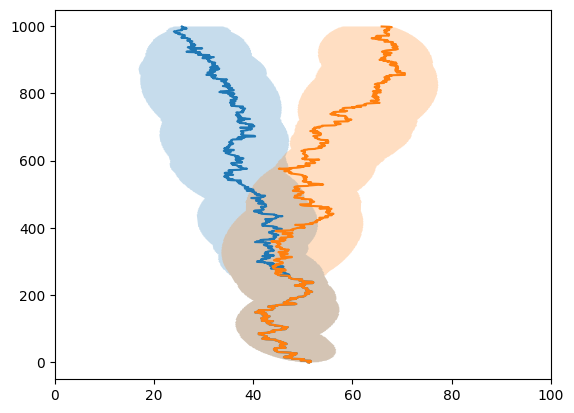

In [120]:
for path in [paths_347[i] for i in (0, 3)]:
    times = []
    true_locations = []
    estimated_locations = []
    estimated_left = []
    estimated_right = []
    for node in path:
        orig_id = np.argwhere(map_347==node)[0][0]
        times.append(just_347.node(node).time)
        true_locations.append(just_347.individual(just_347.node(node).individual).location[0])
        estimated_locations.append(locations_of_nodes[orig_id][0])
        estimated_left.append(locations_of_nodes[orig_id][0]-(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
        estimated_right.append(locations_of_nodes[orig_id][0]+(1.96*math.sqrt(round(variances_in_node_locations[orig_id][0][0]))))
    plt.plot(true_locations, times)
    plt.fill_betweenx(y=times, x1=estimated_left, x2=estimated_right, alpha=0.25, label="estimated")
plt.xlim(0, 100)
plt.show()

In [39]:
#just_17 = ts_final.simplify(samples=[17], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)[0]
#just_17 = simplify_with_recombination(ts=just_17, flag_recomb=False)[0]

nodes = []
for path in paths_17:
    for node in path:
        if node not in nodes:
            nodes.append(node)
nodes = np.sort(nodes)


ts_17 = ts_final.subset(nodes=nodes)


#just_17 = simplify_with_recombination(ts=just_17, flag_recomb=False)[0]

#viz.D3ARG(ts=just_17).draw(width=1000, height=500)

In [27]:
len(paths_17)

118

In [34]:
ts_again = tskit.load("/Users/jameskitchens/Desktop/two_pops_again.trees")

In [24]:
np.random.seed(1)
#cutoff = 40000
samples = list(np.random.choice(ts_again.samples(), 500, replace=False))
ts_again_sim, map_again_sim = ts_again.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [35]:
ts_again.tables.nodes

id,flags,population,individual,time,metadata
0,1,1,0,0,"{'slim_id': 12636694, 'is_null': Fals..."
1,1,1,0,0,"{'slim_id': 12636695, 'is_null': Fals..."
2,1,1,1,0,"{'slim_id': 12636696, 'is_null': Fals..."
3,1,1,1,0,"{'slim_id': 12636697, 'is_null': Fals..."
4,1,1,2,0,"{'slim_id': 12636698, 'is_null': Fals..."
5,1,1,2,0,"{'slim_id': 12636699, 'is_null': Fals..."
6,1,1,3,0,"{'slim_id': 12636700, 'is_null': Fals..."
7,1,1,3,0,"{'slim_id': 12636701, 'is_null': Fals..."
8,1,1,4,0,"{'slim_id': 12636702, 'is_null': Fals..."
9,1,1,4,0,"{'slim_id': 12636703, 'is_null': Fals..."
